In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset
import matplotlib.pyplot as plt
from lstm_cnn_net import lstm_cnn
from lstm_net import LSTM
from cnn_net import MyNet
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [23]:
names = ['AC', 'AD', 'BC', 'BD']
types = ['train', 'val', 'test']
#load data
#mac: /Users/syunsei/Desktop/SII2025/process_data/classifier/
#win: C:\Github_LIU\SII2025\process_data\classifier\
for name in names:
    for type in types:
        globals()[name + '_' + type] = np.load('/Users/syunsei/Desktop/SII2025/process_data/classifier/' + name + '_' + type + '.npy')
        
X_train = np.concatenate((AC_train, AD_train, BC_train, BD_train), axis=0)
X_val = np.concatenate((AC_val, AD_val, BC_val, BD_val), axis=0)
X_test = np.concatenate((AC_test, AD_test, BC_test, BD_test), axis=0)
y_train = np.concatenate((np.zeros(AC_train.shape[0]), np.ones(AD_train.shape[0]), np.ones(BC_train.shape[0]) * 2, np.ones(BD_train.shape[0]) * 3), axis=0)
y_val = np.concatenate((np.zeros(AC_val.shape[0]), np.ones(AD_val.shape[0]), np.ones(BC_val.shape[0]) * 2, np.ones(BD_val.shape[0]) * 3), axis=0)
y_test = np.concatenate((np.zeros(AC_test.shape[0]), np.ones(AD_test.shape[0]), np.ones(BC_test.shape[0]) * 2, np.ones(BD_test.shape[0]) * 3), axis=0)

#归一化
# def min_max_normalize(data):
#     # 初始化归一化后的特征矩阵
#     normalized_features = np.zeros_like(data)
#     # 对每个 dim 进行归一化
#     for i in range(data.shape[1]):
#         dim_values = data[:, :, i]
#         min_val = np.min(dim_values)
#         max_val = np.max(dim_values)
#         # 使用最小-最大归一化公式
#         normalized_features[:, :, i] = (dim_values - min_val) / (max_val - min_val)
#     return normalized_features

# X_train = min_max_normalize(X_train)
# X_val = min_max_normalize(X_val)
# X_test = min_max_normalize(X_test)

#split data into training and testing and validation
'''X_train=np.concatenate ((X_train[:,:,0:3],X_train[:,:,6:9]), axis=2)
X_val=np.concatenate ((X_val[:,:,0:3],X_val[:,:,6:9]), axis=2)
X_test=np.concatenate ((X_test[:,:,0:3],X_test[:,:,6:9]), axis=2)'''
X_train=torch.tensor(X_train,dtype=torch.float32)
X_val=torch.tensor(X_val,dtype=torch.float32)
X_test=torch.tensor(X_test,dtype=torch.float32)
y_train=torch.tensor(y_train,dtype=torch.long)
y_val=torch.tensor(y_val,dtype=torch.long)
y_test=torch.tensor(y_test,dtype=torch.long)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


# #draw X_train
# print(X_train[66].shape)
# plt.plot(X_train[66])
# plt.show()
'''
batch_size = 100
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)'''

#dataset
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=100)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, shuffle=True, batch_size=20)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, shuffle=True, batch_size=20)


torch.Size([715, 301, 12]) torch.Size([46, 301, 12]) torch.Size([47, 301, 12])
torch.Size([715]) torch.Size([46]) torch.Size([47])


In [24]:
#define hyperparameters
sequence_len = 301
input_len = 12
hidden_size = 128
num_layers = 2
num_classes = 4
num_epochs = 50
learning_rate = 0.001

In [25]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [26]:
model = lstm_cnn(input_len, hidden_size, num_layers, num_classes).to(device)
#model = MyNet().to(device)
print(model)

lstm_cnn(
  (conv1): Conv1d(12, 64, kernel_size=(9,), stride=(1,))
  (conv2): Conv1d(12, 32, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(12, 16, kernel_size=(5,), stride=(1,))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
)


In [27]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
def train(num_epochs, model, train_loader, loss_function):
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        for batch, (lifts, labels) in enumerate(train_loader):
            '''lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)'''
            lifts, labels = lifts.to(device), labels.to(device)
            
            outputs = model(lifts)
            loss = loss_function(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch+1) % 2 == 0:
                loss_list.append(loss.item())
                print(f"Epoch [{epoch+1}; Batch {batch+1}/{total_step}]; Loss: {loss.item():.4f}")
                
loss_list = []
#draw learning curve
def plot_learning_curve(loss_list):
    plt.plot(loss_list, label="loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
    
train(num_epochs, model, train_loader, loss_function)
plot_learning_curve(loss_list)


RuntimeError: Given groups=1, weight of size [32, 12, 5], expected input[100, 64, 147] to have 12 channels, but got 64 channels instead

In [9]:
def validate(model, val_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in val_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Validation accuracy: {100 * correct / total}%")

validate(model, val_loader)

Validation accuracy: 82.6086956521739%


Validation accuracy: 82.6086956521739%
[[ 9  1  0  0]
 [ 2  8  0  2]
 [ 1  0 11  0]
 [ 1  1  0 10]]


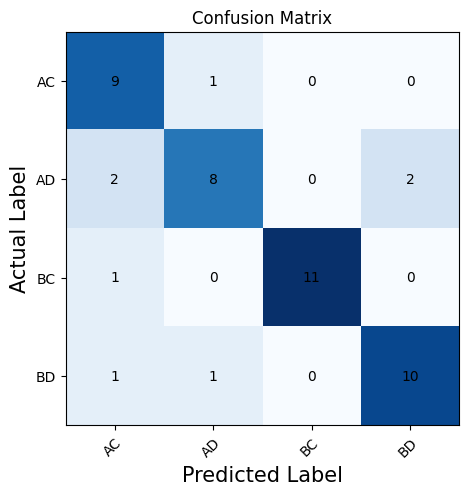

Precision: 0.8314, Recall: 0.8292, F1: 0.8249


(82.6086956521739, 0.8314102564102565, 0.8291666666666667, 0.8249341238471674)

In [11]:
def validate(model, val_loader, sequence_len, input_len, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        for lifts, labels in val_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Accumulate labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
        
        accuracy = 100 * correct / total
        print(f"Validation accuracy: {accuracy}%")

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        print(conf_matrix)
        #plot confusion matrix
        class_labels_conf = ['AC', 'AD', 'BC', 'BD']
        fig, ax = plt.subplots()
        im = ax.imshow(conf_matrix, cmap='Blues')
        ax.set_xticks(np.arange(len(class_labels_conf)))
        ax.set_yticks(np.arange(len(class_labels_conf)))
        ax.set_xticklabels(class_labels_conf)
        ax.set_yticklabels(class_labels_conf)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        for i in range(len(class_labels_conf)):
            for j in range(len(class_labels_conf)):
                text = ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")
        ax.set_title("Confusion Matrix")
        fig.tight_layout()
        plt.ylabel('Actual Label', fontsize=15)
        plt.xlabel('Predicted Label', fontsize=15)
        plt.show()

        # Calculate precision, recall, and F1 scor
        precision = precision_score(all_labels, all_predictions, average='macro')
        recall = recall_score(all_labels, all_predictions, average='macro')
        f1 = f1_score(all_labels, all_predictions, average='macro')
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        return accuracy, precision, recall, f1


# Assuming `model`, `val_loader`, `sequence_len`, `input_len`, and `device` are defined
validate(model, val_loader, sequence_len, input_len, device)





In [33]:
def test(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in test_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Test accuracy: {100 * correct / total}%")

test(model, test_loader)

Test accuracy: 65.95744680851064%


In [34]:
#save model
torch.save(model.state_dict(), "model.pth")
